## Team Members:

### Name: Aryan Aneesh          EID: ama8932

### Name: Hari Shankar          EID: hs33533

### Name: Akshay Unnikrishnan   EID: asu272

In [28]:
# All imports used for the project. This cell must be rerun everytime a new import is added.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Loading the Dataset

We load the training and test datasets using `pandas.read_csv()`, which imports each file into a DataFrame for further exploration and modeling. Storing the data in a dedicated `data/` folder keeps the project organized and makes these paths easy to reference throughout the notebook. This step initializes the core datasets that will be used for all analysis, cleaning, and model development.

In [29]:
train = pd.read_csv('data/cattle_data_train.csv')
test = pd.read_csv('data/cattle_data_test.csv')

### Data Schema
This code cell generates a simple schema overview of the dataset by listing each column, its data type, and the number of missing values it contains. Printing the schema early in the workflow helps us understand the overall structure of the data and quickly identify which fields might need imputation, one-hot encoding, and scaling.

The observation to make when observing the schema is that all but 3 attributes have no missing records: Feed_Quantity_kg, Feed_Quantity_lb (which clearly offers redundant information and can be removed), and Housing_Score. Figuring out whether to remove these records or impute them will be one of the key decisions to make in data cleaning. 


In [30]:
def print_schema(df):
    schema = pd.DataFrame({
        "column": df.columns,
        "dtype": df.dtypes.values,
        "num_missing": df.isna().sum().values,
    })
    display(schema)
    
print_schema(train)

,column,dtype,num_missing
0,Cattle_ID,object,0
1,Breed,object,0
2,Climate_Zone,object,0
3,Management_System,object,0
4,Age_Months,int64,0
5,Weight_kg,float64,0
6,Parity,int64,0
7,Lactation_Stage,object,0
8,Days_in_Milk,int64,0
9,Feed_Type,object,0


### Data Analysis

In this section, we explore the structure and behavior of the dataset to better understand the factors that may influence `Milk_Yield_L`. Some of the techniques we use involve looking at sample entries to see what an entry might contain, observing the distribution of all the attributes, etc. This exploratory analysis helps reveal patterns, outliers, and potential data quality issues, guiding the decisions used to for the data pipeline and our model. 


In [31]:
display(train.head())

,Cattle_ID,Breed,Climate_Zone,Management_System,Age_Months,Weight_kg,Parity,Lactation_Stage,Days_in_Milk,Feed_Type,...,BVD_Vaccine,Rabies_Vaccine,Previous_Week_Avg_Yield,Body_Condition_Score,Milking_Interval_hrs,Date,Farm_ID,Feed_Quantity_lb,Mastitis,Milk_Yield_L
0,CATTLE_133713,Holstein,Tropical,Intensive,114,544.8,4,Mid,62,Concentrates,...,0,1,6.31,3.0,12,2024-01-15,FARM_0301,36.8235,1,12.192634
1,CATTLE_027003,Holstein,Arid,Mixed,136,298.9,4,Mid,213,Crop_Residues,...,0,0,17.16,4.0,12,2023-10-31,FARM_0219,NaN,0,14.717031
2,CATTLE_122459,Holstein,Tropical,Semi_Intensive,64,336.6,4,Late,16,Hay,...,1,0,4.07,3.5,12,2024-05-20,FARM_0802,16.0965,0,14.006142
3,CATTLE_213419,Jersey,Mediterranean,Intensive,58,370.5,1,Early,339,Crop_Residues,...,0,0,10.23,3.0,24,2024-07-22,FARM_0034,40.7925,0,24.324325
4,CATTLE_106260,Guernsey,Subtropical,Intensive,84,641.5,6,Early,125,Mixed_Feed,...,1,1,20.68,3.0,12,2023-01-03,FARM_0695,33.7365,1,12.023074


In [32]:
display(train.describe())

,Age_Months,Weight_kg,Parity,Days_in_Milk,Feed_Quantity_kg,Feeding_Frequency,Water_Intake_L,Walking_Distance_km,Grazing_Duration_hrs,Rumination_Time_hrs,...,Anthrax_Vaccine,IBR_Vaccine,BVD_Vaccine,Rabies_Vaccine,Previous_Week_Avg_Yield,Body_Condition_Score,Milking_Interval_hrs,Feed_Quantity_lb,Mastitis,Milk_Yield_L
count,210000.000000,210000.000000,210000.000000,210000.000000,199519.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,...,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,210000.000000,199519.000000,210000.000000,210000.000000
mean,83.483905,499.930430,3.500395,182.112967,12.014793,2.999119,80.036850,4.034754,6.056710,0.256557,...,0.600381,0.598814,0.599824,0.600824,8.747584,3.394726,12.302438,26.492720,0.099976,15.589156
std,34.648982,144.659172,1.707383,105.051486,3.969247,1.413147,14.987677,1.928529,2.867575,6.115351,...,0.489821,0.490140,0.489935,0.489730,5.901473,0.632831,4.298998,8.741282,0.299969,5.352079
min,24.000000,250.000000,1.000000,1.000000,2.370284,1.000000,14.207737,0.500000,1.000000,-8.808053,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,6.000000,6.615000,0.000000,-5.700324
25%,54.000000,374.200000,2.000000,91.000000,9.283265,2.000000,69.919162,2.650000,4.000000,-4.383302,...,0.000000,0.000000,0.000000,0.000000,4.270000,3.000000,12.000000,20.506500,0.000000,11.822207
50%,83.000000,500.200000,3.000000,182.000000,12.002254,3.000000,80.016973,4.000000,6.000000,-0.818631,...,1.000000,1.000000,1.000000,1.000000,7.710000,3.500000,12.000000,26.460000,0.000000,15.145871
75%,114.000000,625.700000,5.000000,273.000000,14.708920,4.000000,90.119812,5.350000,8.000000,4.051704,...,1.000000,1.000000,1.000000,1.000000,12.410000,4.000000,12.000000,32.413500,0.000000,18.884708
max,143.000000,750.000000,6.000000,364.000000,25.454207,5.000000,149.960210,12.000000,14.000000,31.263406,...,1.000000,1.000000,1.000000,1.000000,38.670000,5.000000,24.000000,55.125000,1.000000,44.555285


### Distribution of Milk Yield

The histogram above shows the distribution of the target variable, `Milk_Yield_L`. The distribution is roughly bell-shaped and centered around 15–20 liters, suggesting that most cows produce milk within this range. Because `Milk_Yield_L` is already close to normally distributed, we don’t need to apply log or other transformations, and can model the target directly without adjustment. One thing that is interesting is a small number of negative yield values, which are likely data entry errors and will need to be addressed during data cleaning.

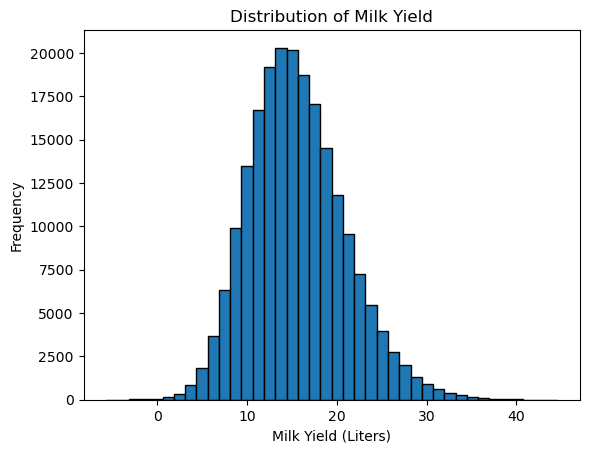

In [33]:
plt.hist(train["Milk_Yield_L"], bins=40, edgecolor='black')
plt.title("Distribution of Milk Yield")
plt.xlabel("Milk Yield (Liters)")
plt.ylabel("Frequency")
plt.show()

### Correlation with Milk Yield

The table above shows the correlation of each numeric feature with the target variable, `Milk_Yield_L`, sorted from strongest to weakest. Weight_kg has the highest positive correlation, suggesting that heavier cows tend to produce more milk. Feed quantity and water intake also show moderate positive correlations. Several features—including Age_Months, Parity, Mastitis, and Days_in_Milk—show negative correlations, indicating that older cows, cows with more pregnancies, and cows with mastitis tend to have lower milk yield. Most other features have very weak or near-zero correlations, meaning they likely contribute little individually.


In [41]:
numeric_df = train.select_dtypes(include = ['number'])
numeric_df.corr()["Milk_Yield_L"].sort_values(ascending = False)

Milk_Yield_L               1.000000
Weight_kg                  0.300464
Feed_Quantity_lb           0.223631
Feed_Quantity_kg           0.223288
Water_Intake_L             0.124911
Rumination_Time_hrs        0.089823
Previous_Week_Avg_Yield    0.089823
IBR_Vaccine                0.072263
Anthrax_Vaccine            0.069642
Rabies_Vaccine             0.068618
Milking_Interval_hrs       0.014734
Grazing_Duration_hrs       0.004350
Housing_Score              0.004008
Humidity_percent           0.002153
Brucellosis_Vaccine        0.002089
BVD_Vaccine                0.000491
Feeding_Frequency          0.000380
HS_Vaccine                -0.000034
BQ_Vaccine                -0.000466
Walking_Distance_km       -0.001538
Body_Condition_Score      -0.001647
Resting_Hours             -0.001653
FMD_Vaccine               -0.002477
Ambient_Temperature_C     -0.042036
Days_in_Milk              -0.062554
Mastitis                  -0.122614
Parity                    -0.236565
Age_Months                -0

### Plotting Numeric Features Against Milk Yield

To better understand how each numeric feature relates to the target variable, we visualize scatter plots of feature values versus `Milk_Yield_L`. Since the dataset is large, we take a random sample of points to make the plots easier to read while still reflecting the underlying trends. These visualizations help reveal linear or non-linear relationships, potential outliers, and overall feature usefulness for modeling.

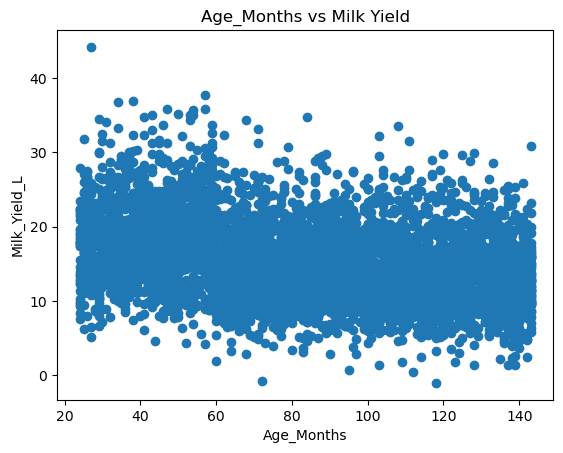

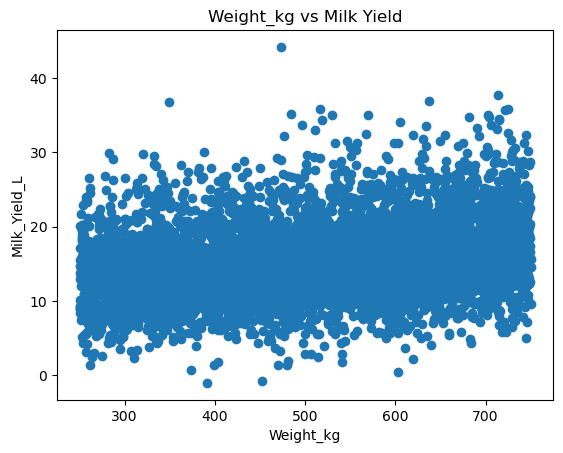

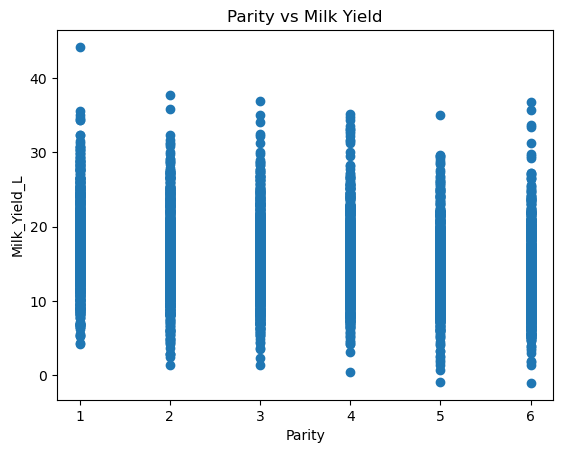

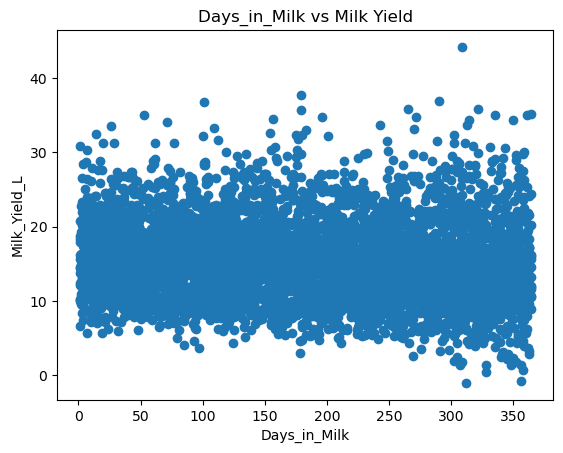

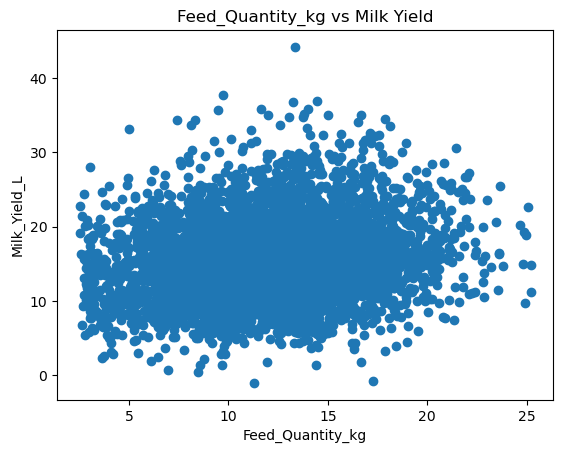

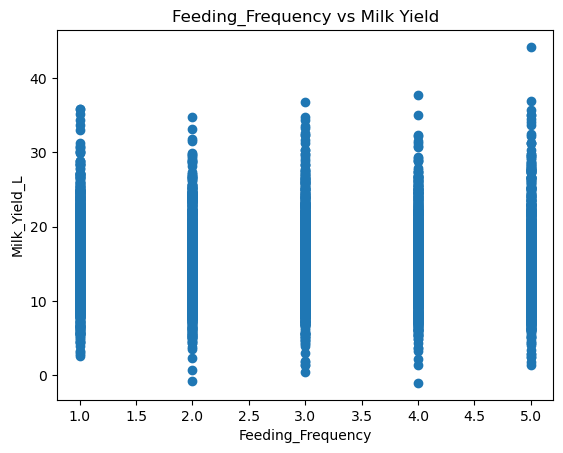

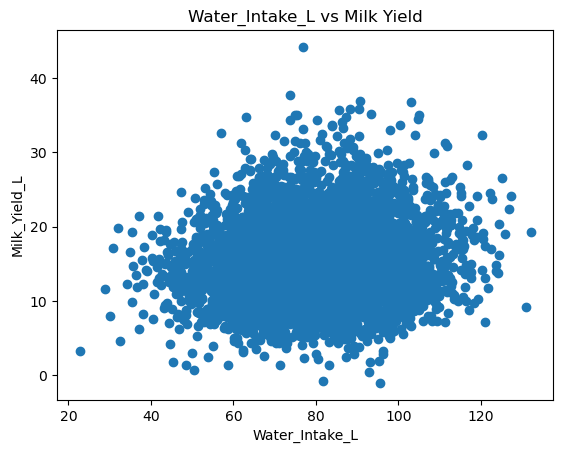

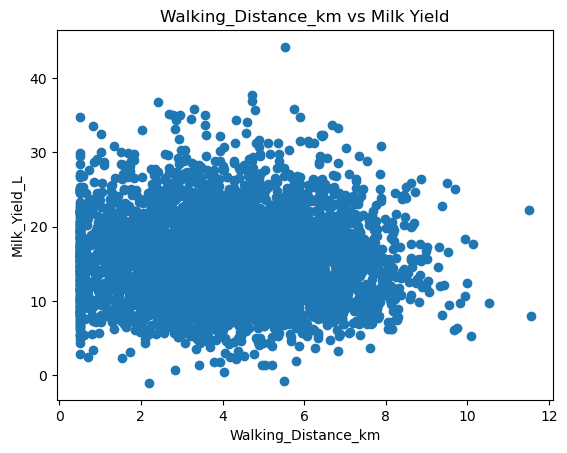

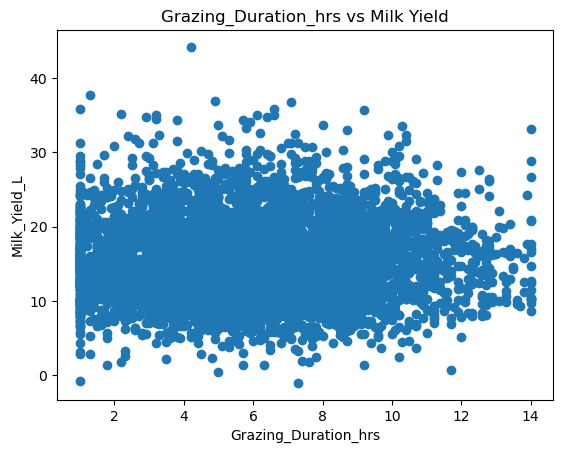

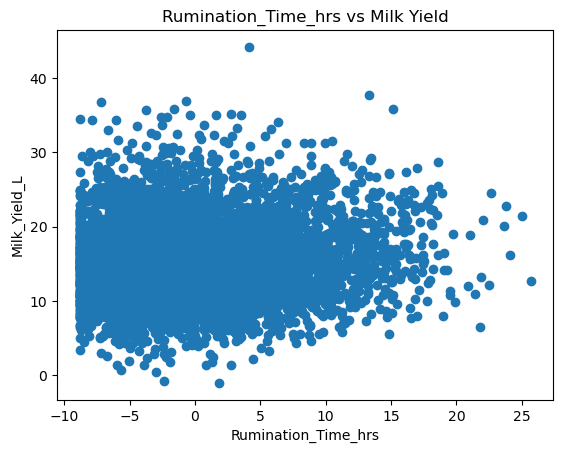

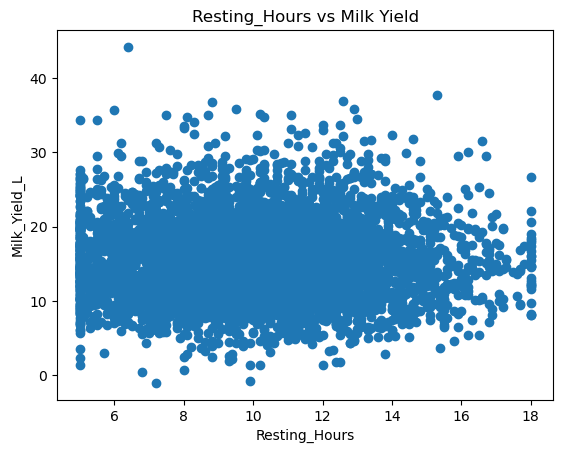

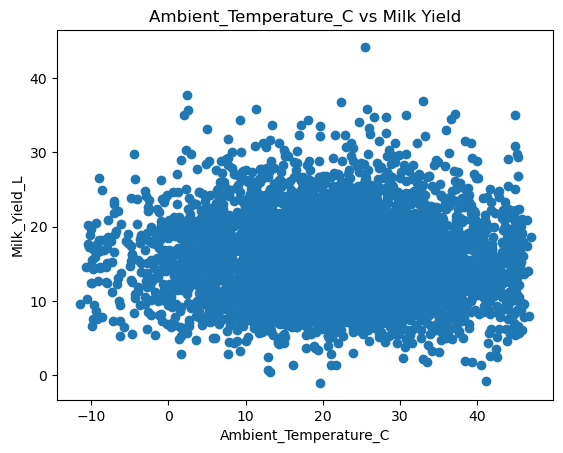

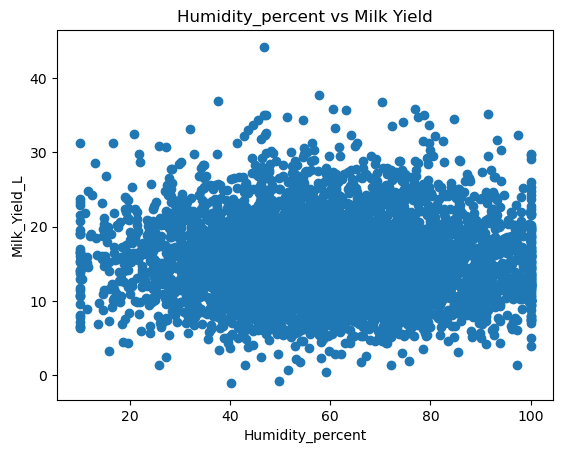

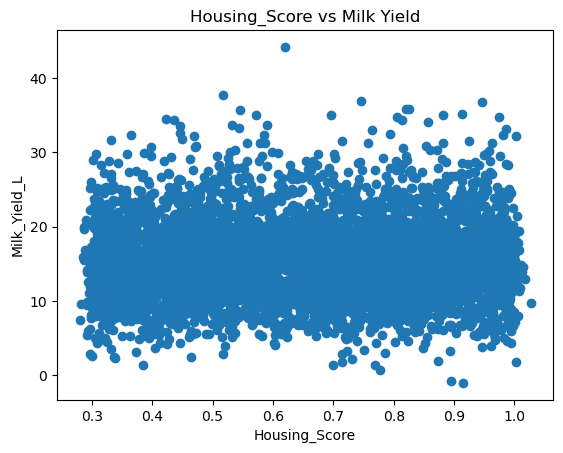

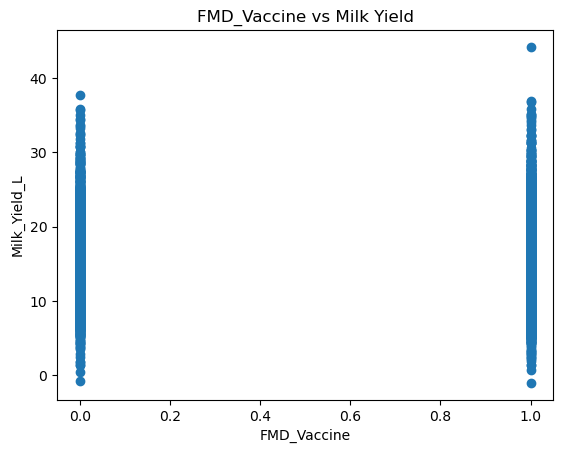

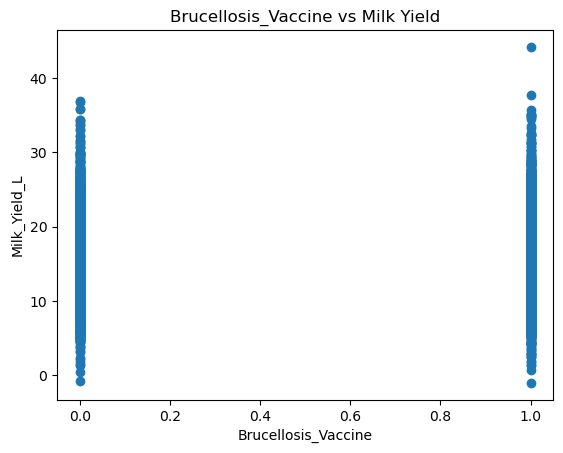

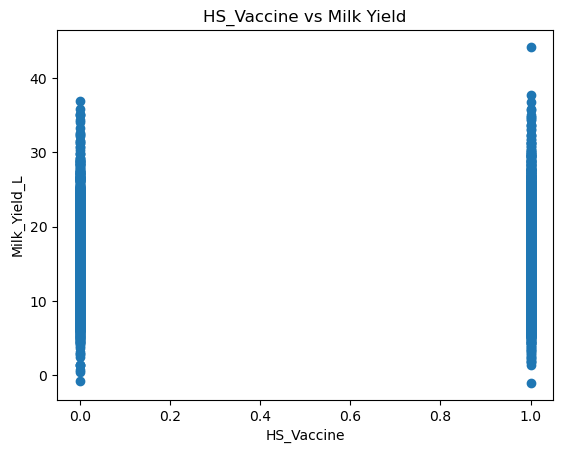

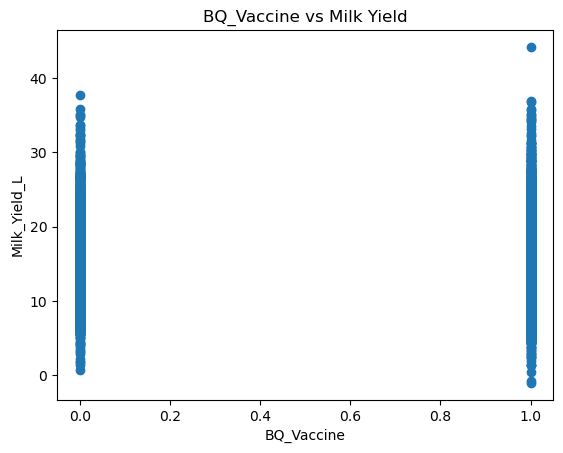

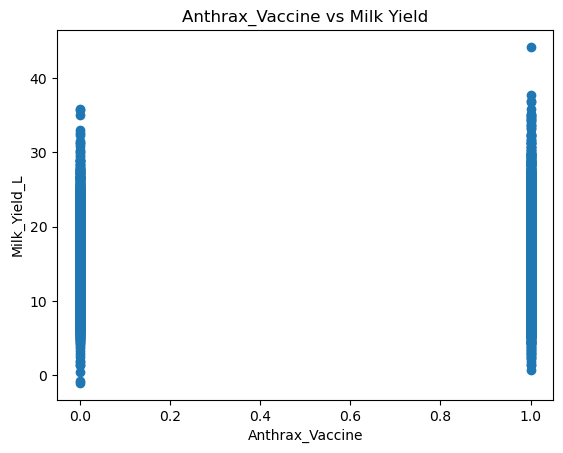

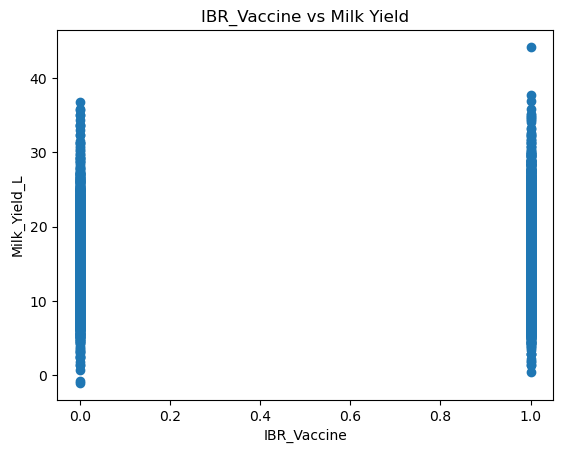

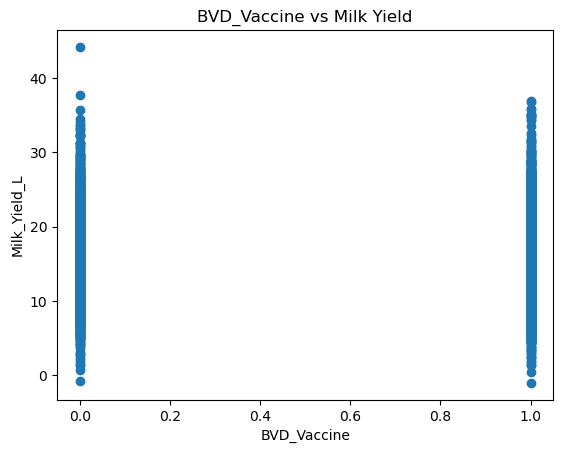

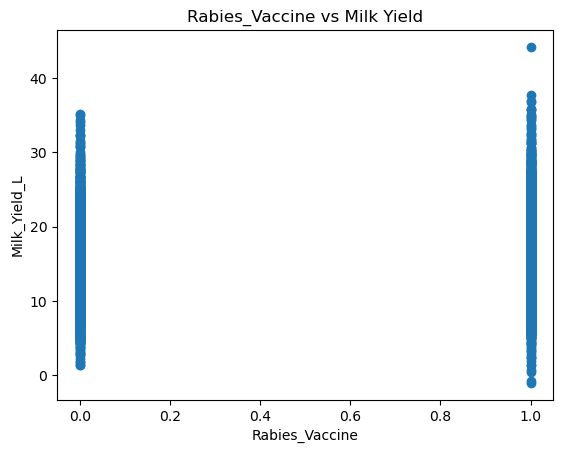

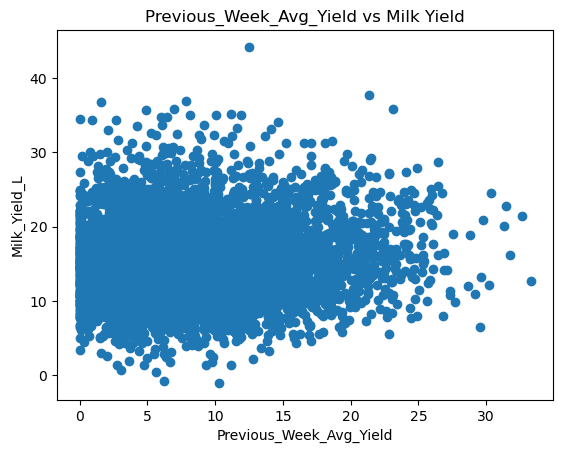

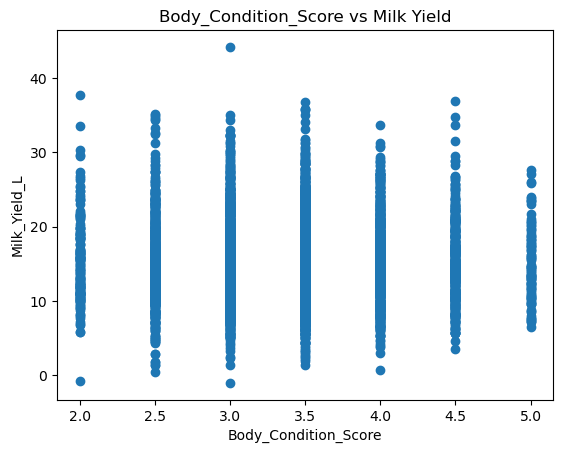

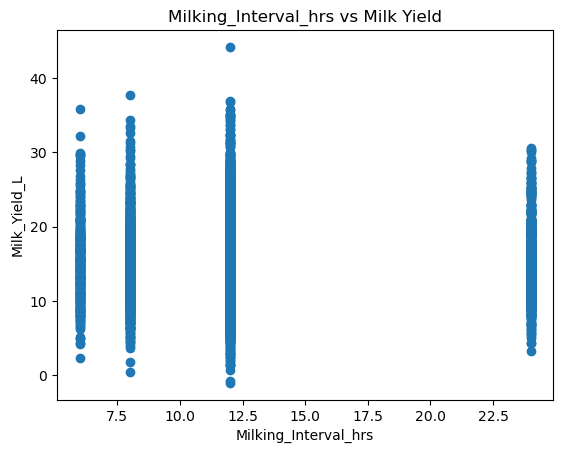

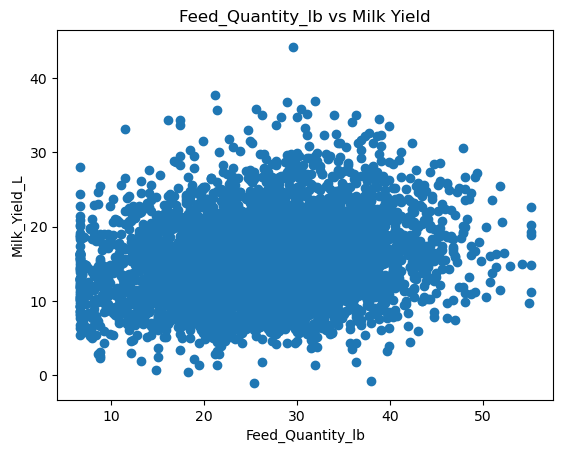

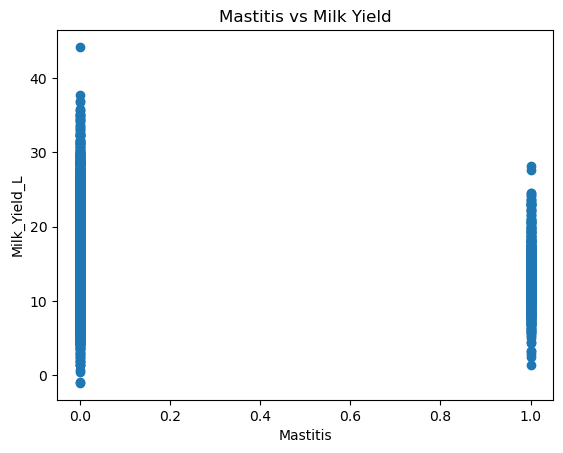

In [49]:
# Retrieve all atrributes with numeric values, dropping the target. 
numeric_cols = train.select_dtypes(include = ['number']).columns
numeric_cols = numeric_cols.drop("Milk_Yield_L")

# Take a sample to avoid cluttering plots. 
sample = train.sample(n=5000)

for col in numeric_cols:
    plt.scatter(sample[col], sample["Milk_Yield_L"])
    plt.xlabel(col)
    plt.ylabel("Milk_Yield_L")
    plt.title(f"{col} vs Milk Yield")
    plt.show()

### Plotting Categorical Features Against Milk Yield

To understand how milk yield varies across different categories, we generate boxplots for each non-numeric feature. Boxplots allow us to compare the distribution of `Milk_Yield_L` across different groups, such as breeds, climate zones, or management systems. These visualizations help identify which categorical features may influence milk yield and guide us in deciding which features could be useful for modeling.


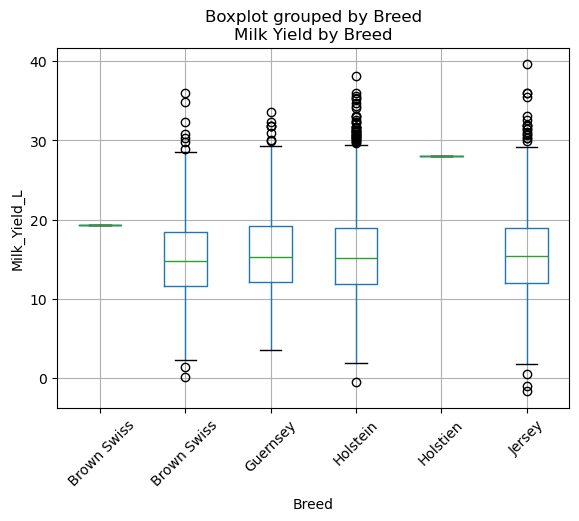

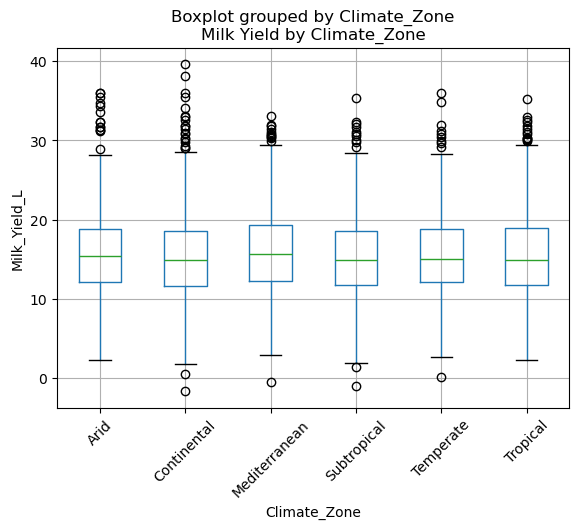

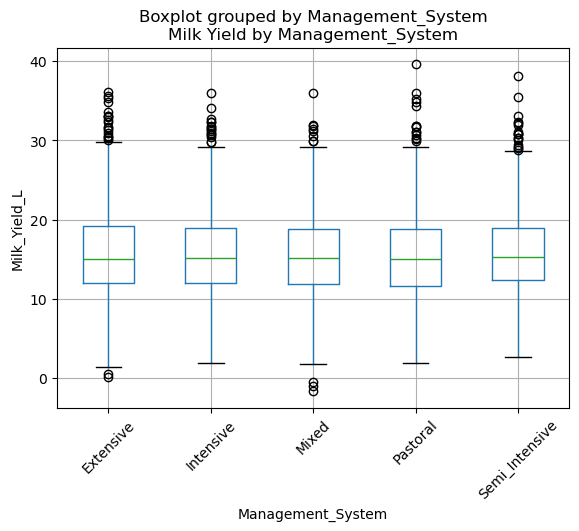

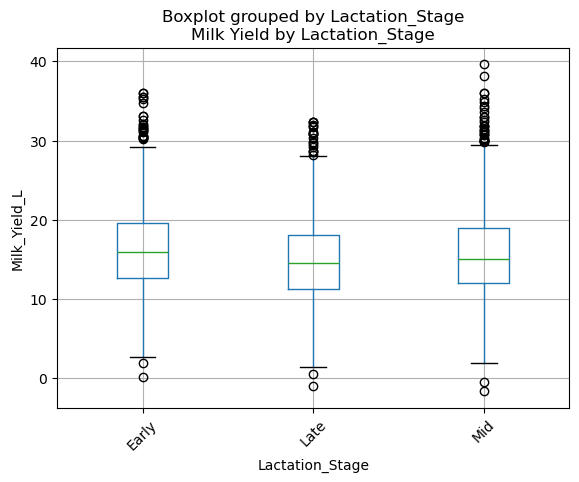

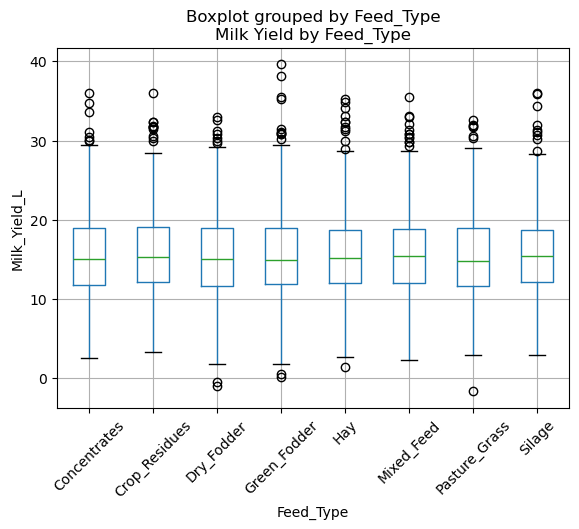

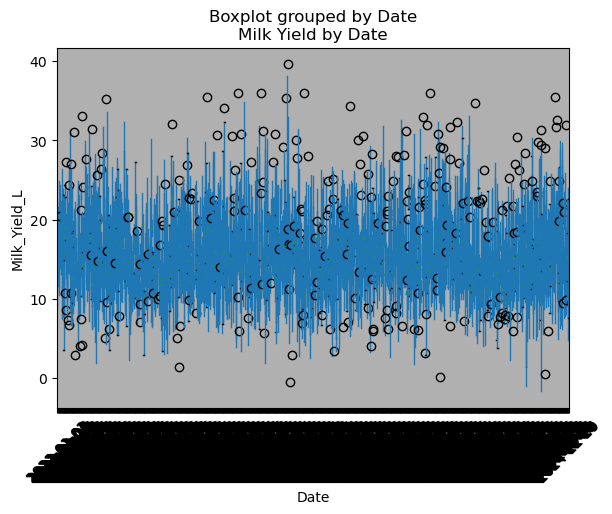

In [54]:
# Retrieve all atrributes with categorical values, dropping identifiers. 
non_numeric_cols = train.select_dtypes(include=['object']).columns
non_numeric_cols = non_numeric_cols.drop("Cattle_ID")
non_numeric_cols = non_numeric_cols.drop("Farm_ID")

# Take a sample to avoid cluttering plots. 
sample = train.sample(n=5000)

for col in non_numeric_cols:
    sample.boxplot(column = "Milk_Yield_L", by = col, rot = 45)
    plt.title(f"Milk Yield by {col}")
    plt.xlabel(col)
    plt.ylabel("Milk_Yield_L")
    plt.show()


### Observations from Categorical Feature Boxplots

The boxplots above illustrate how milk yield varies across each non-numeric categorical features. Most categorical variables—such as Breed, Climate_Zone, Management_System, Lactation_Stage, and Feed_Type—show overlapping distributions, suggesting only modest differences in median milk yield across categories. The Date column contains hundreds of unique values, producing an unreadable plot and offering no meaningful grouping; this confirms that Date should be transformed into more useful temporal features (e.g., month, day of week) rather than treated as a raw categorical variable.

## Data Cleaning

Before building predictive models, it is essential to ensure the dataset is accurate, consistent, and usable. In this stage, we address issues identified during exploratory analysis—such as missing values, impossible or inconsistent measurements, redundant features, and non-informative identifiers.

### Dropping Columns

We remove the `Cattle_ID` and `Farm_ID` columns because they are unique identifiers that do not contain meaningful predictive information for modeling. Keeping these columns would not help the model learn patterns and could introduce noise, so we drop them before further preprocessing.

Since feed quantity is represented using kg and lbs, we can drop one of them to remove the redundant attribute. 

In [55]:
# Drop identifiers
train.drop(["Cattle_ID", "Farm_ID"], axis=1, inplace=True)

# Drop the redundant column
train.drop("Feed_Quantity_lb", axis=1, inplace=True)

### Fixing Negative Values

Some features, such as `Milk_Yield_L` and `Rumination_Time_hrs`, represent physical measurements that cannot be negative. During cleaning, we address these issues by either clipping negative values to zero or removing records where these measurements fall below zero. This ensures the dataset only contains biologically valid observations and prevents the model from learning from impossible or erroneous data. In this case, we choce to drop impossible target values since these will confuse loss functions and corrupt model training, but we chose to preserve records with a negative rumination time, clipping it to zero, to keep as much of our data intact as possible.

In [ ]:
# Drop negative target values
train = train[train["Milk_Yield_L"] >= 0]

# Fix invalid rumination values
train["Rumination_Time_hrs"] = train["Rumination_Time_hrs"].clip(lower=0)


### Imputing Missing Values

To handle missing data in the dataset, we applied median imputation to the features `Feed_Quantity_kg` and `Housing_Score`. Median imputation is robust to outliers and provides a stable replacement value without introducing bias from extreme observations.

In [ ]:
# Median imputation for Feed_Quantity_kg
feed_median = train["Feed_Quantity_kg"].median()
train["Feed_Quantity_kg"] = train["Feed_Quantity_kg"].fillna(feed_median)

# Median imputation for Housing_Score
housing_score_median = train["Housing_Score"].median()
train["Housing_Score"] = train["Housing_Score"].fillna(housing_score_median)

### Extracting Date-Based Features

We converted the `Date` column into useful numerical features. Since milk production is affected by seasonal changes rather than specific weekdays or weekends, we extracted only the `Month` feature, which captures seasonal variation in temperature, feed availability, and environmental conditions. The original date column was then removed.

In [56]:
train["Date"] = pd.to_datetime(train["Date"])
train["Month"] = train["Date"].dt.month
train.drop("Date", axis=1, inplace=True)